---
title: "Processing III: Merging multimodal data"
---

In the previous scripts, we have preprocessed various motion and acoustic data. In this script, we will merge the data into a single file per trial. These data include:

- Balance Board data
- Kinematics
- Joint angles
- Joint moments
- Amplitude envelope
- f0
- formants
- spectral tilt

#TODO: add voice quality and spectral centroid

In [ ]:
#| code-fold: true
#| code-summary: Code to prepare environment

# packages
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

curfolder = os.getcwd()

# folders with processed data
MTfolder_processed = curfolder + '\\TS_motiontracking\\'
ACfolder_processed = curfolder + '\\TS_acoustics\\'
# folder to save merged data
TSmerged = curfolder + '\\TS_merged\\'

# prepare all files
bbfiles = glob.glob(MTfolder_processed + '/bb*.csv')
idfiles = glob.glob(MTfolder_processed + '/id*.csv')
ikfiles = glob.glob(MTfolder_processed + '/ik*.csv')
mtfiles = glob.glob(MTfolder_processed + '/mt*.csv')
envfiles = glob.glob(ACfolder_processed + '/env*.csv')
f0files = glob.glob(ACfolder_processed + '/f0*.csv')
formants = glob.glob(ACfolder_processed + '/praat_formants*.csv')

Because each timeseries is sampling at different frequency, we opt for 500 Hz as the final sampling rate we will merge on. That means that we will interpolate all missing data (using linear interpolation) to match this frequency.

Additionally, we will adapt the formants such that we only consider values that are present within a range of an amplitude peak, or where f0 is present, or both. These two situations can be considered as yielding in the most reliable formant values.

Finally, we will also use inverse kinematics and dynamics to calculate power (as joint moment × joint velocity).

In [ ]:
#| eval: false

desired_sr = 0.5    # this is the sr we are going to merge on (in Hz/sec)

error_log = []

for file in bbfiles:

    bb_df = pd.read_csv(file)
    # get trial id
    trialid = bb_df['TrialID'][0]

    print('working on ' + trialid)
    
    # find the same trialid in idfiles
    id_file = [x for x in idfiles if trialid in x]
    try:
        id_df = pd.read_csv(id_file[0])
    except IndexError:
        print('IndexError: ' + trialid + ' not found')
        errormessage = 'IndexError: ' + trialid + 'not found for ID'
        error_log.append(errormessage)
        continue
    
    # find the same trialid in mtfiles
    mt_file = [x for x in mtfiles if trialid in x]
    try:
        mt_df = pd.read_csv(mt_file[0])
    except IndexError:
        print('IndexError: ' + trialid + ' not found')
        errormessage = 'IndexError: ' + trialid + 'not found for MT'
        error_log.append(errormessage)
        continue
    # rename Time to time
    mt_df.rename(columns={'Time': 'time'}, inplace=True)

    # find the same trialid in envfiles
    env_file = [x for x in envfiles if trialid in x]
    try:
        env_df = pd.read_csv(env_file[0])
    except IndexError:
        print('IndexError: ' + trialid + ' not found')
        errormessage = 'IndexError: ' + trialid + ' not found for ENV'
        error_log.append(errormessage)
        continue
    
    # rename trialID to TrialID
    env_df.rename(columns={'trialID': 'TrialID'}, inplace=True)

    # find the same trialid in f0files
    f0_file = [x for x in f0files if trialid in x]
    try:
        f0_df = pd.read_csv(f0_file[0])
    except IndexError:
        print('IndexError: ' + trialid + ' not found')
        errormessage = 'IndexError: ' + trialid + ' not found for F0'
        error_log.append(errormessage)
        continue

    # rename time_ms to time
    f0_df.rename(columns={'time_ms': 'time'}, inplace=True)
    # rename ID to TrialID
    f0_df.rename(columns={'ID': 'TrialID'}, inplace=True)

    # find the same trialid in ikfiles
    ik_file = [x for x in ikfiles if trialid in x]
    try:
        ik_df = pd.read_csv(ik_file[0])
    except IndexError:
        print('IndexError: ' + trialid + ' not found')
        errormessage = 'IndexError: ' + trialid + ' not found for IK'
        error_log.append(errormessage)
        continue

    # find the same trialid in formants
    formants_file = [x for x in formants if trialid in x]
    try:
        formants_df = pd.read_csv(formants_file[0])
    except IndexError:
        print('IndexError: ' + trialid + 'not found')
        errormessage = 'IndexError: ' + trialid + 'not found for formants'
        error_log.append(errormessage)
        continue

    # rename triald to TrialID
    formants_df.rename(columns={'trialid': 'TrialID'}, inplace=True)
    formants_df = formants_df[['time', 'f1', 'f2', 'f3', 'TrialID']]
    formants_df['time'] = formants_df['time'] * 1000

    # write error log
    with open(TSmerged + '/error_log.txt', 'w') as f:
        for item in error_log:
            f.write("%s\n" % item)


    ############## MERGING ########################

    #### regularize sr in bb
    time_new = np.arange(0, max(bb_df['time']), 1/desired_sr)
    bb_interp = pd.DataFrame({'time': time_new})
    
    # interpolate all columns in samplebb 
    colstoint = bb_df.columns
    colstoint = [x for x in colstoint if 'time' not in x]
    colstoint = [x for x in colstoint if 'TrialID' not in x]
    colstoint = [x for x in colstoint if 'FileInfo' not in x]

    for col in colstoint:
        bb_interp[col] = bb_df[col].interpolate(method='linear', x = bb_interp['time'])

    # add trialid and time
    bb_interp['TrialID'] = trialid
    bb_interp['FileInfo'] = bb_df['FileInfo'][0]
    
    ########### merge the bb_interp with env
    # merge the two dataframes
    merge1 = pd.merge(bb_interp, env_df, on=['time', 'TrialID'], how='outer')

    # interpolate missing values of envelope and audio
    colstoint = merge1.columns
    colstoint = [x for x in colstoint if 'audio' in x or 'envelope' in x]

    for col in colstoint: 
        merge1[col] = merge1[col].interpolate(method='linear', x = merge1['time'])

    # now we can kick out all vlaues where COPc is NaN
    merge1 = merge1[~np.isnan(merge1['COPc'])]

    ########### merge with ID
    # merge the two dataframes
    merge2 = pd.merge(merge1, id_df, on=['time', 'TrialID'], how='outer')

    # get cols of sampleid
    colstoint = id_df.columns
    colstoint = [x for x in colstoint if 'time' not in x]
    colstoint = [x for x in colstoint if 'TrialID' not in x]

    # interpolate 
    for col in colstoint:
        merge2[col] = merge2[col].interpolate(method='linear', x = merge2['time'])

    # now we can kick out all values where COPc is NaN to get sampling rate back to 500	
    merge2 = merge2[~np.isnan(merge2['COPc'])]

    ########### merge with MT
    # merge the two dataframes
    merge3 = pd.merge(merge2, mt_df, on=['time', 'TrialID'], how='outer')

    # get cols of samplemt
    colstoint = mt_df.columns
    colstoint = [x for x in colstoint if 'time' not in x]
    colstoint = [x for x in colstoint if 'TrialID' not in x]

    # interpolate missing values of from mt
    for col in colstoint:
        merge3[col] = merge3[col].interpolate(method='linear', x = merge3['time'])

    # now we can kick out all values where COPc is NaN
    merge3 = merge3[~np.isnan(merge3['COPc'])]

    ########### merge with F0
    # for interpolation, we need to again parse f0 into chunks of non-NaN values
    f0_df['chunk'] = None

    # annotate chunks of non-NaN values
    chunk = 0
    for index, row in f0_df.iterrows():
        if np.isnan(row['f0']):
            continue
        else:
            f0_df.loc[index, 'chunk'] = chunk
            # if the next value is NaN or this is the last row, increase the chunk
            if index == len(f0_df)-1:
                continue
            elif np.isnan(f0_df.loc[index+1, 'f0']):
                chunk += 1

    chunks = f0_df['chunk'].unique()

    # skip if chunks are empty (that means that there is no f0 trace)
    if len(chunks) > 1:
        # ignore the first chunk (None)
        chunks = chunks[1:]

    # now we can merge
    merge4 = pd.merge(merge3, f0_df, on=['time', 'TrialID'], how='outer')

    # we ignore the None chunk above, so if there is some trace, None should not be within chunks
    if None not in chunks:
        for chunk in chunks:
            # get the first and last row of the chunk
            firstrow = merge4[merge4['chunk'] == chunk].index[0]
            lastrow = merge4[merge4['chunk'] == chunk].index[-1]
            # fill all inbetween with the chunk number
            merge4.loc[firstrow:lastrow, 'chunk'] = chunk
            # get the rows of the chunk
            chunkrows = merge4[merge4['chunk'] == chunk].copy()
            # interpolate
            chunkrows['f0'] = chunkrows['f0'].interpolate(method='linear', x = chunkrows['time'])
            # put the interpolated chunk back to the merge4
            merge4.loc[merge4['chunk'] == chunk, 'f0'] = chunkrows['f0']

    # get rid of the chunk column
    merge4.drop('chunk', axis=1, inplace=True)

    # now we can drop all rows where COPc is NaN
    merge4 = merge4[~np.isnan(merge4['COPc'])]

    ########### merge with IK
    merge5 = pd.merge(merge4, ik_df, on=['time', 'TrialID'], how='outer')

    # get cols of sampleik
    colstoint = ik_df.columns
    colstoint = [x for x in colstoint if 'time' not in x]
    colstoint = [x for x in colstoint if 'TrialID' not in x]

    # interpolate missing values of from ik
    for col in colstoint:
        merge5[col] = merge5[col].interpolate(method='linear', x = merge5['time'])

    # now we can kick out all values where COPc is NaN
    merge5 = merge5[~np.isnan(merge5['COPc'])]

    ########### merge with formants
    merge6 = pd.merge(merge5, formants_df, on=['time', 'TrialID'], how='outer')

    # get cols of sampleformants
    colstoint = formants_df.columns
    colstoint = [x for x in colstoint if 'time' not in x]
    colstoint = [x for x in colstoint if 'TrialID' not in x]

    # interpolate missing values of from formants
    for col in colstoint:
        merge6[col] = merge6[col].interpolate(method='linear', x = merge6['time'])

    # now we can kick out all values where COPc is NaN
    merge6 = merge6[~np.isnan(merge6['COPc'])]

    # this is final df
    merge_final = merge6     

    ############## FORMANT ADAPTATION ########################

    # find peaks in envelope, with min=mean
    peaks, _ = scipy.signal.find_peaks(merge_final['envelope'], height=np.mean(merge_final['envelope']))
    # get widths of the peaks
    widths = scipy.signal.peak_widths(merge_final['envelope'], peaks, rel_height=0.95)
    # peak width df with starts and ends
    peak_widths = pd.DataFrame({'start': widths[2], 'end': widths[3]})

    # now create a new column env_weak_width, and put 0s everywhere, and 1s in the intervals of the width
    merge_final['env_peak_width'] = 0
    for index, row in peak_widths.iterrows():
        merge_final.loc[int(row['start']):int(row['end']), 'env_peak_width'] = 1

    # now we will create formant columns, where we will keep only formants in the intervals of env_pak_width OR where f0 is not NaN
    merge_final['f1_clean_f0'] = merge_final['f1']
    merge_final['f2_clean_f0'] = merge_final['f2']
    merge_final['f3_clean_f0'] = merge_final['f3']

    # where f0 is NaN, we will put NaN - these are formants during f0 only
    merge_final.loc[np.isnan(merge_final['f0']), 'f1_clean_f0'] = np.nan
    merge_final.loc[np.isnan(merge_final['f0']), 'f2_clean_f0'] = np.nan
    merge_final.loc[np.isnan(merge_final['f0']), 'f3_clean_f0'] = np.nan

    # we will also create formants, where we will keep only those in the intervals of env_pak_width
    merge_final['f1_clean_env'] = merge_final['f1']
    merge_final['f2_clean_env'] = merge_final['f2']
    merge_final['f3_clean_env'] = merge_final['f3']

    # where env_peak_width is 0, we will put NaN - these are formants during envelope peaks only
    merge_final.loc[merge_final['env_peak_width'] == 0, 'f1_clean_env'] = np.nan
    merge_final.loc[merge_final['env_peak_width'] == 0, 'f2_clean_env'] = np.nan
    merge_final.loc[merge_final['env_peak_width'] == 0, 'f3_clean_env'] = np.nan

    ## now we create formants where we copy values from clean_env and clean_f0
    merge_final['f1_clean'] = merge_final['f1_clean_env']
    merge_final['f2_clean'] = merge_final['f2_clean_env']
    merge_final['f3_clean'] = merge_final['f3_clean_env']

    # where formant is now NaN, copy values from f_clean_f0 in case there is a value
    merge_final.loc[np.isnan(merge_final['f1_clean']), 'f1_clean'] = merge_final['f1_clean_f0']
    merge_final.loc[np.isnan(merge_final['f2_clean']), 'f2_clean'] = merge_final['f2_clean_f0']
    merge_final.loc[np.isnan(merge_final['f3_clean']), 'f3_clean'] = merge_final['f3_clean_f0']

    # now calculate formant velocities (but only for the f_clean)
    merge_final['f1_clean_vel'] = np.insert(np.diff(merge_final['f1_clean']), 0, 0)
    merge_final['f2_clean_vel'] = np.insert(np.diff(merge_final['f2_clean']), 0, 0)
    merge_final['f3_clean_vel'] = np.insert(np.diff(merge_final['f3_clean']), 0, 0)

    # smooth
    merge_final['f1_clean_vel'] = scipy.signal.savgol_filter(merge_final['f1_clean_vel'], 5, 3)
    merge_final['f2_clean_vel'] = scipy.signal.savgol_filter(merge_final['f2_clean_vel'], 5, 3)
    merge_final['f3_clean_vel'] = scipy.signal.savgol_filter(merge_final['f3_clean_vel'], 5, 3)

    ########## POWER ####################
    groups = ['lowerbody', 'leg', 'head', 'arm']

    for group in groups:
        # get all columns that contain group
        cols = [x for x in merge_final.columns if group in x]

        # get all columns that contain 'moment_sum'
        torque = [x for x in cols if 'moment_sum' in x]
        # but not change
        torque = [x for x in torque if 'change' not in x][0]

        # get all columns that contain 'angSpeed_sum'
        angSpeed = [x for x in cols if 'angSpeed_sum' in x][0]

        # get power which is moment * angSpeed
        merge_final[group + '_power'] = merge_final[torque] * merge_final[angSpeed]
        # smooth
        merge_final[group + '_power'] = scipy.signal.savgol_filter(merge_final[group + '_power'], 15,3)
    
    # write to csv
    merge_final.to_csv(TSmerged + '/merged_' + trialid + '.csv', index=False)  

working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\TS_motiontracking\bb_0_1_1_p0.csv
IndexError: 0_1_1_p0not found
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\TS_motiontracking\bb_0_1_10_p1.csv
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\TS_motiontracking\bb_0_1_18_p0.csv
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\TS_motiontracking\bb_0_1_2_p0.csv
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\TS_motiontracking\bb_0_1_8_p0.csv
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\TS_motiontracking\bb_0_1_9_p1.csv
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\TS_motiontracking\bb_0_2_111_p1.csv
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\TS_motiontracking\bb_0_2_112_p1.csv
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\TS_motiontracking\bb_0_1_0_p0.csv
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\TS_motiontracking\bb_0_1_3_p0.csv
working on e:\FLESH_Cont

,time,left_back,right_forward,right_back,left_forward,COPXc,COPYc,COPc,TrialID,FileInfo,...,f1_clean,f2_clean,f3_clean,f1_clean_vel,f2_clean_vel,f3_clean_vel,lowerbody_power,leg_power,head_power,arm_power
0,0.0,1.121945,0.812051,1.480789,1.403169,-0.000252,-0.000123,0.000280,0_2_113_p1,p1_huilen_geluiden_c0,...,NaN,NaN,NaN,NaN,NaN,NaN,216.431048,9.991220,4.303524,19.227950
1,2.0,1.122196,0.812064,1.480782,1.403227,-0.000150,-0.000100,0.000180,0_2_113_p1,p1_huilen_geluiden_c0,...,NaN,NaN,NaN,NaN,NaN,NaN,215.268919,9.975152,4.272850,19.125385
2,4.0,1.122379,0.812091,1.480792,1.403254,-0.000064,-0.000083,0.000105,0_2_113_p1,p1_huilen_geluiden_c0,...,NaN,NaN,NaN,NaN,NaN,NaN,213.953743,9.957135,4.238850,19.012073
3,6.0,1.122505,0.812128,1.480816,1.403257,0.000007,-0.000072,0.000072,0_2_113_p1,p1_huilen_geluiden_c0,...,NaN,NaN,NaN,NaN,NaN,NaN,212.502553,9.937432,4.202005,18.889815
4,8.0,1.122583,0.812174,1.480855,1.403241,0.000065,-0.000065,0.000092,0_2_113_p1,p1_huilen_geluiden_c0,...,NaN,NaN,NaN,NaN,NaN,NaN,210.932385,9.916308,4.162795,18.760412
5,10.0,1.122625,0.812226,1.480908,1.403212,0.000111,-0.000062,0.000126,0_2_113_p1,p1_huilen_geluiden_c0,...,NaN,NaN,NaN,NaN,NaN,NaN,209.260272,9.894028,4.121700,18.625665
6,12.0,1.122637,0.812281,1.480972,1.403172,0.000146,-0.000061,0.000158,0_2_113_p1,p1_huilen_geluiden_c0,...,NaN,NaN,NaN,NaN,NaN,NaN,207.503250,9.870855,4.079202,18.487376
7,14.0,1.122628,0.812338,1.481048,1.403127,0.000172,-0.000063,0.000183,0_2_113_p1,p1_huilen_geluiden_c0,...,NaN,NaN,NaN,NaN,NaN,NaN,205.678353,9.847055,4.035780,18.347347
8,16.0,1.122604,0.812396,1.481133,1.403078,0.000190,-0.000067,0.000201,0_2_113_p1,p1_huilen_geluiden_c0,...,NaN,NaN,NaN,NaN,NaN,NaN,203.830896,9.823382,3.992840,18.211085
9,18.0,1.122571,0.812453,1.481227,1.403030,0.000200,-0.000071,0.000213,0_2_113_p1,p1_huilen_geluiden_c0,...,NaN,NaN,NaN,NaN,NaN,NaN,201.941212,9.799528,3.949800,18.076407


Here is an example of the file containing all the data

In [10]:
#| echo: false

merged_files = glob.glob(TSmerged + '/merged*.csv')
sample = pd.read_csv(merged_files[33]) 

# Display
sample.head(20)

,time,left_back,right_forward,right_back,left_forward,COPXc,COPYc,COPc,TrialID,FileInfo,...,f1_clean,f2_clean,f3_clean,f1_clean_vel,f2_clean_vel,f3_clean_vel,lowerbody_power,leg_power,head_power,arm_power
0,0.0,1.087906,0.849228,1.540655,1.346573,0.000260,0.000547,0.000606,0_1_41_p0,p0_dood_gebaren,...,NaN,NaN,NaN,NaN,NaN,NaN,215.092279,23.613285,7.761380,18.340923
1,2.0,1.087654,0.849621,1.540857,1.346962,0.000284,0.000484,0.000561,0_1_41_p0,p0_dood_gebaren,...,494.632105,2062.393799,2866.779369,NaN,NaN,NaN,211.683164,23.457411,7.759782,18.184178
2,4.0,1.087443,0.849953,1.541027,1.347263,0.000295,0.000431,0.000522,0_1_41_p0,p0_dood_gebaren,...,494.632105,2062.393799,2866.779369,NaN,NaN,NaN,207.968723,23.284358,7.757365,18.011697
3,6.0,1.087268,0.850234,1.541165,1.347490,0.000296,0.000388,0.000488,0_1_41_p0,p0_dood_gebaren,...,494.632105,2062.393799,2866.779369,NaN,NaN,NaN,204.005692,23.096572,7.754155,17.825885
4,8.0,1.087122,0.850469,1.541271,1.347654,0.000289,0.000353,0.000456,0_1_41_p0,p0_dood_gebaren,...,494.632105,2062.393799,2866.779369,0.000000,0.000000,0.000000,199.850807,22.896499,7.750177,17.629146
5,10.0,1.086998,0.850665,1.541347,1.347767,0.000274,0.000326,0.000426,0_1_41_p0,p0_dood_gebaren,...,494.632105,2062.393799,2866.779369,0.000000,0.000000,0.000000,195.560805,22.686586,7.745459,17.423886
6,12.0,1.086891,0.850827,1.541393,1.347837,0.000255,0.000306,0.000398,0_1_41_p0,p0_dood_gebaren,...,494.632105,2062.393799,2866.779369,0.000000,0.000000,0.000000,191.192423,22.469277,7.740026,17.212509
7,14.0,1.086797,0.850962,1.541411,1.347874,0.000232,0.000292,0.000372,0_1_41_p0,p0_dood_gebaren,...,494.632105,2062.393799,2866.779369,0.000000,0.000000,0.000000,186.802396,22.247021,7.733903,16.997421
8,16.0,1.086710,0.851073,1.541400,1.347885,0.000206,0.000282,0.000349,0_1_41_p0,p0_dood_gebaren,...,494.632105,2062.393799,2866.779369,0.000000,0.000000,0.000000,182.567081,22.026964,7.727108,16.785712
9,18.0,1.086628,0.851164,1.541363,1.347876,0.000178,0.000277,0.000329,0_1_41_p0,p0_dood_gebaren,...,494.632105,2062.393799,2866.779369,0.000000,0.000000,0.000000,178.416261,21.806142,7.719620,16.574460


And here we visualize some of the timeseries

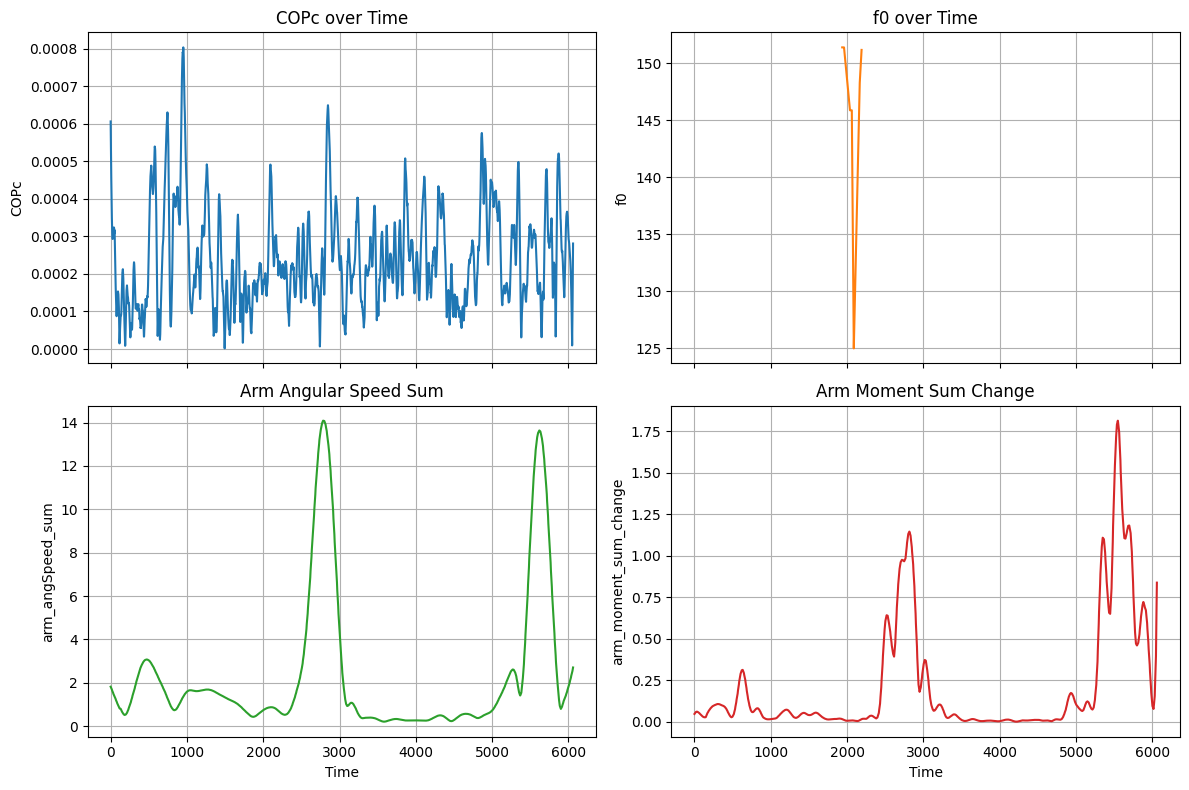

In [11]:
#| echo: false

# Melt the dataframe to long format for easier plotting
df_melted = sample.melt(id_vars=["time"], value_vars=["COPc", "f0", "arm_angSpeed_sum", "arm_moment_sum_change"], 
                     var_name="Variable", value_name="Value")

# Set up the figure
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

# Define variables and titles
variables = ["COPc", "f0", "arm_angSpeed_sum", "arm_moment_sum_change"]
titles = ["COPc over Time", "f0 over Time", "Arm Angular Speed Sum", "Arm Moment Sum Change"]

# Define a color palette
palette = sns.color_palette("tab10", len(variables))

# Loop through subplots and plot each variable
for ax, var, title, color in zip(axes.flat, variables, titles, palette):
    sns.lineplot(data=df_melted[df_melted["Variable"] == var], x="time", y="Value", ax=ax, color=color)
    ax.set_title(title)
    ax.set_xlabel("Time")
    ax.set_ylabel(var)
    ax.grid(True)

plt.tight_layout()
plt.show()